In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Functions import*

In [3]:
from pycaret.classification import*

In [4]:
# Load data 
path = '/data/'
application = pd.read_csv(path + 'application_train.csv') 
bureau = pd.read_csv(path + 'bureau.csv') 
prev_application = pd.read_csv(path + 'previous_application.csv') 

# Preprocessing

In [5]:
application_fe = preprocess_application(application)
bureau_fe = preprocess_bureau(bureau)

In [6]:
prev_application_fe = preprocess_prevapp(prev_application)

In [7]:
data = merge_data(application_fe, bureau_fe, prev_application_fe)

# Pipeline Setup

In [8]:
categorical_var = [col for col in data.columns if data.dtypes[col] == 'object']
numerical_var = [col for col in data.columns if (col not in categorical_var) and (col != 'TARGET')]

pycaret_setup = setup(data = data, target = 'TARGET', session_id=123, 
                      ignore_features = ['SK_ID_CURR'], 
                      categorical_features = categorical_var,
                      numeric_features = numerical_var,  
                      
                      # preprocessing
                      train_size = 0.8,
                      numeric_imputation = 'median',
                      normalize = True, 
                      normalize_method = 'zscore', 
                      transformation = True,
                      transformation_method = 'yeo-johnson',
                      
                      # feature selection,
                      ignore_low_variance = True, 
                      remove_multicollinearity = True,
                      multicollinearity_threshold = 0.8,
                      feature_selection = True,
                      feature_selection_threshold = 0.13, 
                       fold = 10
                      ) 

,Description,Value
0,session_id,123
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(307507, 115)"
5,Missing Values,True
6,Numeric Features,105
7,Categorical Features,8
8,Ordinal Features,False
9,High Cardinality Features,False


In [81]:
get_config('X')

,DAYS_BIRTH,INCOME_ANNUITY_DIFF,PREVAPP_AMT_ANNUITY_LAST,ANNUITY_INCOME_RATIO,FLAG_EMP_PHONE,BUREAU_TOTAL_DEBT,REGION_POPULATION_RELATIVE,REG_CITY_NOT_LIVE_CITY,CODE_GENDER_F,REGION_RATING_CLIENT_W_CITY,...,DAYS_REGISTRATION,PREVAPP_ANNUITY_GOODS_LAST,FLAG_DOCUMENT_3,BUREAU_DAYS_DIFF_AVG,DAYS_ID_PUBLISH,BUREAU_ACTIVE_LOANS_PCT,PREVAPP_DAYS_LAST_DUE_1ST_VERSION_LAST,NAME_INCOME_TYPE_Working,BUREAU_TOTAL_CREDIT,CREDIT_TERM
0,1.560429,0.762729,-0.223168,-0.595462,0.468625,-0.133464,0.073451,-0.290814,0.0,-0.046988,...,0.262785,-0.245073,0.638184,-0.195598,0.672824,-0.486379,-0.141131,1.0,-0.231514,-0.622058
1,-0.204379,1.276220,-0.682859,-0.434532,0.468625,-0.827417,-1.742716,-0.290814,1.0,-2.107040,...,1.182604,-0.245086,0.638184,1.365737,1.609149,-0.486379,-0.589453,0.0,-0.053938,1.705158
2,-0.708435,-1.299132,-0.970716,-0.965126,0.468625,-0.827417,-0.865602,-0.290814,0.0,-0.046988,...,0.061671,-0.245086,-1.566946,1.246844,0.430075,-1.646083,-0.309665,1.0,-1.218528,-0.121508
3,-0.699542,-0.301069,1.498831,0.630620,0.468625,-0.333977,-1.121721,-0.290814,1.0,-0.046988,...,-1.306422,-0.245015,0.638184,0.053586,0.487079,0.012982,-0.210208,1.0,-0.118774,-1.540033
4,-0.899356,-0.412028,1.090041,0.214859,0.468625,-0.827417,0.784927,-0.290814,0.0,-0.046988,...,0.045464,-0.244995,-1.566946,-1.715984,-0.194971,-1.646083,-0.320615,1.0,-1.293016,0.323787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,1.594431,0.129830,-0.709163,0.155151,0.468625,-0.333977,1.000408,-0.290814,0.0,-2.107040,...,-1.021318,-0.245093,-1.566946,0.053586,0.750885,0.012982,-0.166382,1.0,-0.118774,-1.750889
307503,-1.078952,-1.318586,-0.090357,0.051697,-2.133902,-0.333977,0.565987,-0.290814,1.0,-0.046988,...,0.021161,-0.245054,0.638184,0.053586,-0.688630,0.012982,-0.665717,0.0,-0.118774,0.199682
307504,0.210188,0.016749,-1.285590,0.393093,0.468625,1.756942,-1.532465,-0.290814,1.0,1.880539,...,-0.627257,-0.245093,0.638184,-1.188897,-1.615226,0.446607,-0.759677,1.0,1.477995,0.217855
307505,0.934931,0.435100,-1.703014,-0.657363,0.468625,-0.827417,-1.488657,3.438621,1.0,-0.046988,...,0.647875,-0.245119,0.638184,-1.715984,1.302214,-1.646083,-0.146369,0.0,-1.475471,-0.354362


# Cost Function and Score

In [10]:
# cost function
print('Median')
print(application_fe[['AMT_CREDIT', "AMT_ANNUITY"]].median())
print('Mean')
print(application_fe[['AMT_CREDIT', "AMT_ANNUITY"]].mean())

Median
AMT_CREDIT     513531.0
AMT_ANNUITY     24903.0
dtype: float64
Mean
AMT_CREDIT     599028.596733
AMT_ANNUITY     27108.666786
dtype: float64


In [11]:
from sklearn import metrics
# TN: customers who repay the loan, cost = median yearly interest income
COST_TN = 25000
# FN: customers who don't repay the loan - coast = 50% median credit amount
COST_FN = -500000*0.5
# FP: customers whom didn't get a loan but would have repay, cost = loss equal to TN cost
COST_FP = -COST_TN*0.01
# TP: customers whom didn't get a loan and would have been defaulters
COST_TP = 0

def custom_cost(y_true, y_pred):
    conf_mat = metrics.confusion_matrix(y_true, y_pred)
    nb_TN = conf_mat[0,0]
    nb_FN = conf_mat[1,0]
    nb_FP = conf_mat[0,1]
    nb_TP = conf_mat[1,1]
    cost = nb_TN*COST_TN + nb_FN*COST_FN + nb_TP*COST_TP + nb_FP*COST_FP
    cost = round(cost)
    return(cost) 

def custom_score(y_true, y_pred):
    conf_mat = metrics.confusion_matrix(y_true, y_pred)
    nb_TN = conf_mat[0,0]
    nb_FN = conf_mat[1,0]
    nb_FP = conf_mat[0,1]
    nb_TP = conf_mat[1,1]
    
    cost = nb_TN*COST_TN + nb_FN*COST_FN + nb_TP*COST_TP + nb_FP*COST_FP
    best = (nb_TN + nb_FP)*COST_TN + (nb_FN + nb_TP)*COST_TP
    baseline = (nb_TN + nb_FP)*COST_TN + (nb_FN + nb_TP)*COST_FN
    
    score = (cost - baseline) / (best - baseline)
    return(score) 

In [12]:
remove_metric('mcc')
remove_metric('kappa')
add_metric(id="custom_cost", name="Custom Cost", score_func=custom_cost)
add_metric(id="custom_score", name="Custom Score", score_func=custom_score)

Name                                              Custom Score
Display Name                                      Custom Score
Score Function       <function custom_score at 0x7f9f8841ab80>
Scorer                               make_scorer(custom_score)
Target                                                    pred
Args                                                        {}
Greater is Better                                         True
Multiclass                                                True
Custom                                                    True
Name: custom_score, dtype: object

# Compare Models

In [ ]:
# best_model = compare_models(include = ['lr','lightgbm','ada', 'rf'], sort = 'custom_score, n_select = 4)

In [13]:
# Light GBM
lgbm = create_model('lightgbm', class_weight='balanced')

,Accuracy,AUC,Recall,Prec.,F1,Custom Cost,Custom Score
0,0.7011,0.7514,0.6673,0.1654,0.2650,231101750.0000,0.3271
1,0.7009,0.7441,0.6467,0.1618,0.2589,221786000.0000,0.3084
2,0.7077,0.7540,0.6598,0.1675,0.2672,231871500.0000,0.3287
3,0.7007,0.7504,0.6658,0.1649,0.2644,230200250.0000,0.3253
4,0.7008,0.7527,0.6724,0.1660,0.2663,233172500.0000,0.3313
5,0.6987,0.7485,0.6548,0.1621,0.2598,223968250.0000,0.3128
6,0.7064,0.7573,0.6699,0.1685,0.2693,235533500.0000,0.3361
7,0.7011,0.7522,0.6729,0.1663,0.2667,233599500.0000,0.3322
8,0.7037,0.7587,0.6764,0.1682,0.2694,236738250.0000,0.3385
9,0.7041,0.7544,0.6628,0.1662,0.2657,230973000.0000,0.3269


In [15]:
y = predict_model(lgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Custom Cost,Custom Score
0,Light Gradient Boosting Machine,0.6982,0.7548,0.6821,0.1659,0.2669,590952750,0.3358


In [16]:
# Logistic Regression
lr = create_model('lr', class_weight='balanced')

,Accuracy,AUC,Recall,Prec.,F1,Custom Cost,Custom Score
0,0.6630,0.7191,0.6628,0.1473,0.2411,205419750.0000,0.2754
1,0.6611,0.7176,0.6548,0.1453,0.2379,200662250.0000,0.2659
2,0.6633,0.7213,0.6598,0.1470,0.2405,204298500.0000,0.2732
3,0.6637,0.7229,0.6749,0.1495,0.2448,211268250.0000,0.2872
4,0.6643,0.7256,0.6754,0.1498,0.2453,211846500.0000,0.2884
5,0.6599,0.7210,0.6553,0.1449,0.2374,200104500.0000,0.2648
6,0.6666,0.7266,0.6668,0.1495,0.2442,209440000.0000,0.2836
7,0.6611,0.7248,0.6623,0.1465,0.2399,203983250.0000,0.2726
8,0.6645,0.7276,0.6709,0.1492,0.2441,209925000.0000,0.2845
9,0.6669,0.7247,0.6603,0.1486,0.2425,206695000.0000,0.2780


In [82]:
y = predict_model(lr)

,Model,Accuracy,AUC,Recall,Prec.,F1,Custom Cost,Custom Score
0,Logistic Regression,0.6597,0.7229,0.6664,0.1462,0.2398,513655500,0.2734


# Optimization Logistic Regression

In [21]:
# tuning on cost score
tuned_lr = tune_model(lr, optimize = 'custom_score', fold = 10)

,Accuracy,AUC,Recall,Prec.,F1,Custom Cost,Custom Score
0,0.6630,0.7191,0.6628,0.1473,0.2411,205419750.0000,0.2754
1,0.6611,0.7176,0.6548,0.1453,0.2379,200662250.0000,0.2659
2,0.6633,0.7213,0.6598,0.1470,0.2405,204298500.0000,0.2732
3,0.6636,0.7229,0.6749,0.1495,0.2447,211167250.0000,0.2870
4,0.6643,0.7256,0.6754,0.1499,0.2453,211871750.0000,0.2884
5,0.6599,0.7210,0.6553,0.1449,0.2374,200104500.0000,0.2648
6,0.6666,0.7266,0.6668,0.1495,0.2442,209465250.0000,0.2836
7,0.6610,0.7248,0.6623,0.1465,0.2399,203932750.0000,0.2725
8,0.6645,0.7276,0.6709,0.1492,0.2441,209925000.0000,0.2845
9,0.6669,0.7247,0.6603,0.1486,0.2425,206695000.0000,0.2780


In [22]:
print(tuned_lr)

LogisticRegression(C=0.472, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [23]:
# Predict model
y_lr = predict_model(tuned_lr, raw_score = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Custom Cost,Custom Score
0,Logistic Regression,0.6597,0.7229,0.6664,0.1463,0.2399,513731250,0.2735


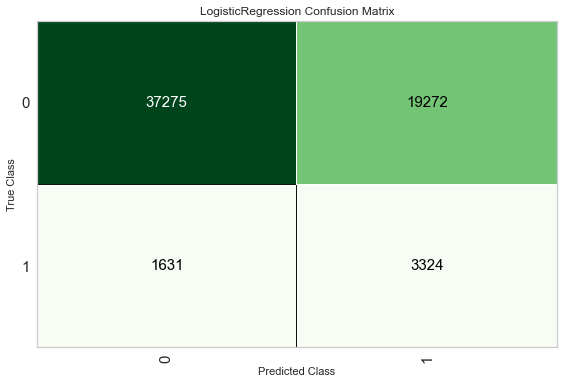

In [27]:
# Confusion matrix
plot_model(tuned_lr, 'confusion_matrix')

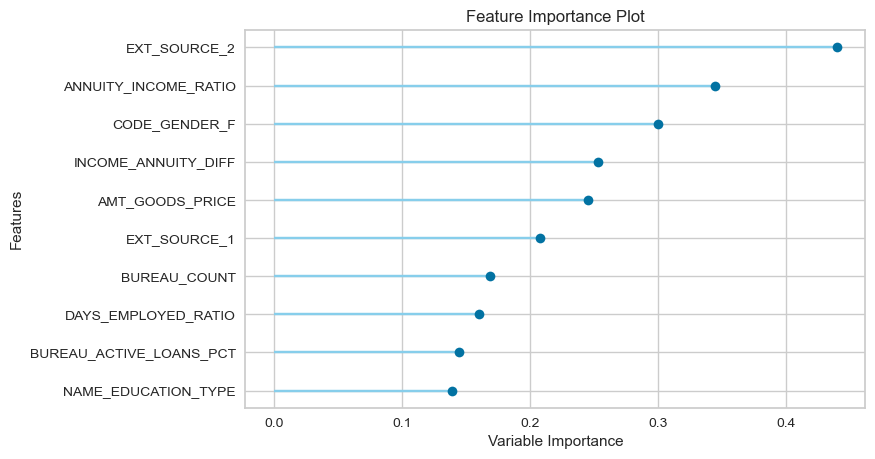

In [24]:
# feature importance
plot_model(tuned_lr,'feature')

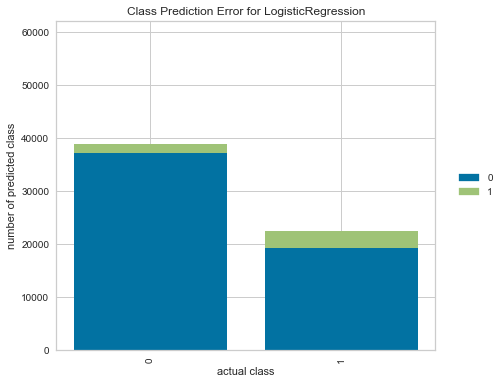

In [25]:
plot_model(tuned_lr,'error')

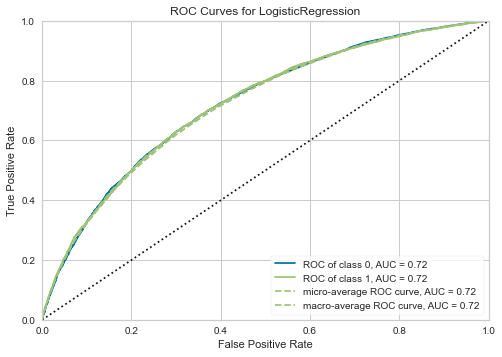

In [26]:
plot_model(tuned_lr,'auc')

# Optimization Light GBM

In [27]:
# tuning on cost score
tuned_lgbm = tune_model(lgbm, optimize = 'custom_score', fold =10)

,Accuracy,AUC,Recall,Prec.,F1,Custom Cost,Custom Score
0,0.7226,0.7518,0.6412,0.1725,0.2718,232772000.0000,0.3305
1,0.7242,0.7449,0.6286,0.1712,0.2691,228188500.0000,0.3213
2,0.7259,0.7493,0.6215,0.1709,0.2681,226102500.0000,0.3171
3,0.7234,0.7486,0.6346,0.1718,0.2704,230355250.0000,0.3256
4,0.7203,0.7500,0.6407,0.1711,0.2701,231133250.0000,0.3272
5,0.7241,0.7484,0.6311,0.1716,0.2699,229236750.0000,0.3234
6,0.7297,0.7533,0.6261,0.1740,0.2723,230423250.0000,0.3258
7,0.7241,0.7514,0.6381,0.1729,0.2720,232383250.0000,0.3298
8,0.7233,0.7540,0.6472,0.1740,0.2742,235898500.0000,0.3368
9,0.7270,0.7525,0.6387,0.1746,0.2742,234350250.0000,0.3337


In [28]:
# predict model
y_lgbm = predict_model(tuned_lgbm, raw_score = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Custom Cost,Custom Score
0,Light Gradient Boosting Machine,0.7212,0.7520,0.6434,0.1717,0.2711,583580000,0.3299


In [30]:
print(tuned_lgbm)

LGBMClassifier(bagging_fraction=0.7, bagging_freq=6, boosting_type='gbdt',
               class_weight='balanced', colsample_bytree=1.0,
               feature_fraction=0.5, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=66, min_child_weight=0.001,
               min_split_gain=0.4, n_estimators=90, n_jobs=-1, num_leaves=90,
               objective=None, random_state=123, reg_alpha=0.0005,
               reg_lambda=0.1, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


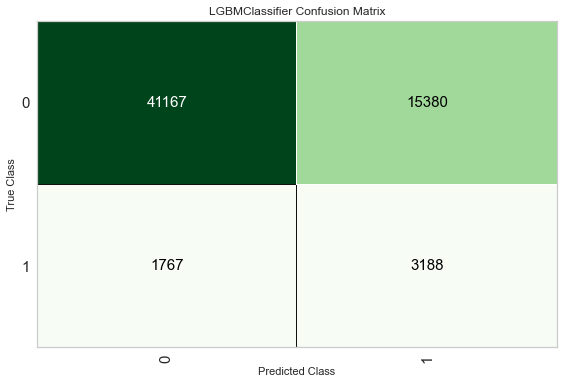

In [31]:
# confusion matrix
plot_model(tuned_lgbm, 'confusion_matrix')

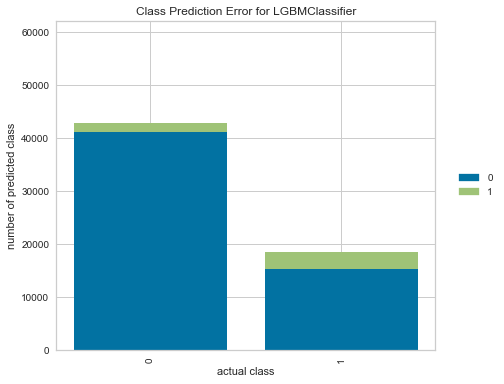

In [33]:
plot_model(tuned_lgbm,'error')

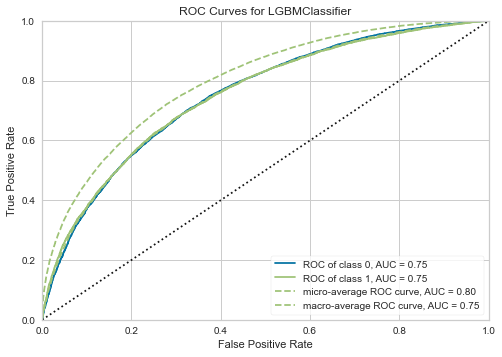

In [35]:
plot_model(tuned_lgbm,'auc')

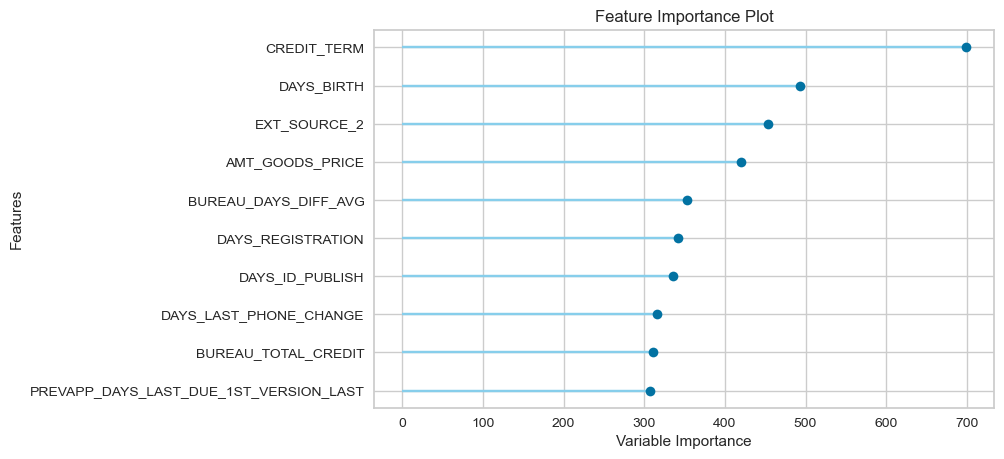

In [36]:
# feature importance
plot_model(tuned_lgbm,'feature')

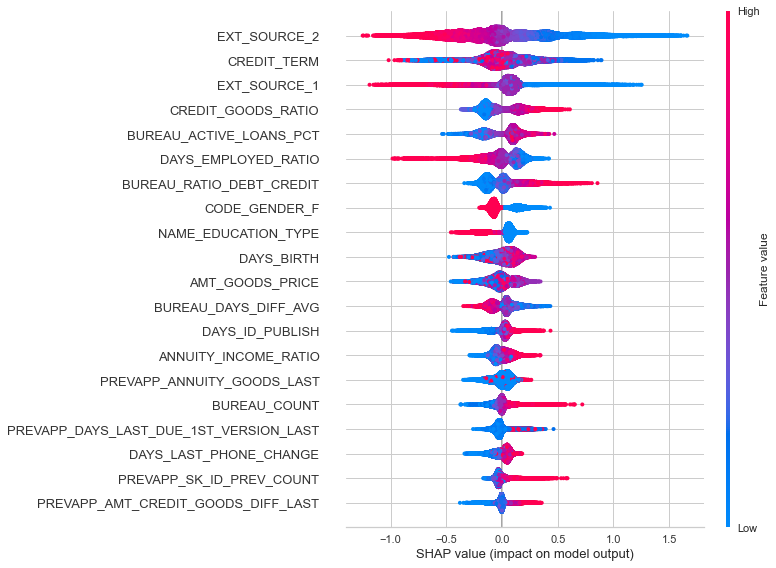

In [37]:
# SHAP feature importance
interpret_model(tuned_lgbm)

# Blending

In [38]:
# blending best lr and lgbm model with soft (probas)
blend_soft = blend_models(estimator_list = [tuned_lgbm, tuned_lr], method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Custom Cost,Custom Score
0,0.7032,0.7449,0.6548,0.1644,0.2627,226821250.0000,0.3185
1,0.7032,0.7406,0.6467,0.1630,0.2604,223225250.0000,0.3113
2,0.7045,0.7447,0.6346,0.1616,0.2576,218614000.0000,0.3020
3,0.7036,0.7451,0.6537,0.1644,0.2627,226624250.0000,0.3181
4,0.7032,0.7475,0.6663,0.1663,0.2661,231965250.0000,0.3289
5,0.7063,0.7445,0.6537,0.1658,0.2645,228291000.0000,0.3215
6,0.7087,0.7496,0.6417,0.1650,0.2625,224361500.0000,0.3136
7,0.7051,0.7478,0.6623,0.1666,0.2662,231329000.0000,0.3276
8,0.7072,0.7507,0.6568,0.1668,0.2660,230195000.0000,0.3254
9,0.7054,0.7488,0.6457,0.1640,0.2615,224139500.0000,0.3132


In [39]:
# predict model
y_blend_soft = predict_model(blend_soft, raw_score = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Custom Cost,Custom Score
0,Voting Classifier,0.6996,0.7468,0.6644,0.1638,0.2628,573447250,0.3217


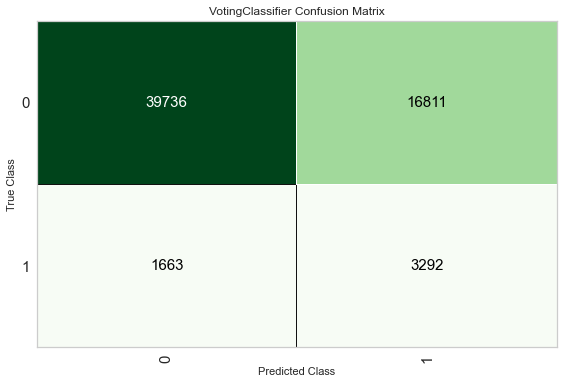

In [40]:
# confusion matrix
plot_model(blend_soft, 'confusion_matrix')

# Stacking

In [41]:
# stacking models with lr as meta model
stacked_lr = stack_models(estimator_list = [tuned_lgbm, tuned_lr],
                           meta_model=tuned_lr)

,Accuracy,AUC,Recall,Prec.,F1,Custom Cost,Custom Score
0,0.6824,0.7516,0.6975,0.1612,0.2619,232971750.0000,0.3309
1,0.6830,0.7458,0.6839,0.1593,0.2584,227282250.0000,0.3194
2,0.6853,0.7487,0.6729,0.1586,0.2567,223802250.0000,0.3124
3,0.6831,0.7487,0.6895,0.1603,0.2601,229855500.0000,0.3246
4,0.6801,0.7502,0.6915,0.1592,0.2588,228835500.0000,0.3226
5,0.6849,0.7487,0.6860,0.1605,0.2602,229343000.0000,0.3236
6,0.6913,0.7549,0.6774,0.1622,0.2617,229537000.0000,0.3240
7,0.6842,0.7524,0.6900,0.1609,0.2609,230737000.0000,0.3264
8,0.6847,0.7548,0.6965,0.1621,0.2630,233936500.0000,0.3329
9,0.6887,0.7531,0.6870,0.1625,0.2628,232191250.0000,0.3294


In [42]:
# predict model
y_stacked_lr = predict_model(stacked_lr, raw_score = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Custom Cost,Custom Score
0,Stacking Classifier,0.6814,0.7520,0.6940,0.1598,0.2598,578256000,0.3256


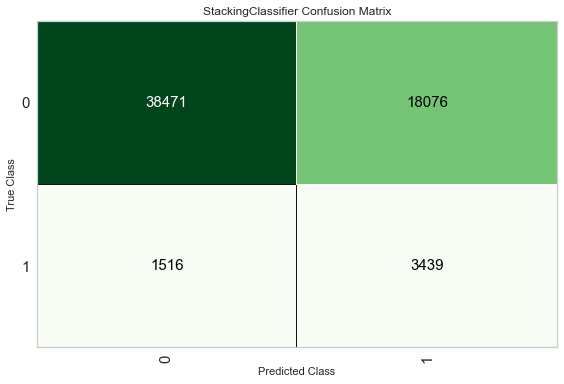

In [43]:
# confusion matrix
plot_model(stacked_lr, 'confusion_matrix')

In [44]:
# stacking models with lgbm as meta model
stacked_lgbm = stack_models(estimator_list = [tuned_lgbm, tuned_lr],
                           meta_model=tuned_lgbm)

,Accuracy,AUC,Recall,Prec.,F1,Custom Cost,Custom Score
0,0.7163,0.7520,0.6568,0.1717,0.2722,235850750.0000,0.3367
1,0.7148,0.7423,0.6251,0.1653,0.2615,220757250.0000,0.3063
2,0.7208,0.7509,0.6341,0.1702,0.2684,228514500.0000,0.3219
3,0.7180,0.7471,0.6482,0.1711,0.2708,233090500.0000,0.3311
4,0.7148,0.7521,0.6492,0.1695,0.2688,231520000.0000,0.3280
5,0.7126,0.7488,0.6452,0.1676,0.2661,228358750.0000,0.3217
6,0.7224,0.7542,0.6402,0.1722,0.2714,232171250.0000,0.3293
7,0.7204,0.7509,0.6371,0.1706,0.2691,229636000.0000,0.3242
8,0.7183,0.7552,0.6548,0.1724,0.2730,236164000.0000,0.3374
9,0.7227,0.7537,0.6462,0.1734,0.2735,235070250.0000,0.3352


In [45]:
# predict model
y_stacked_lgbm = predict_model(stacked_lgbm, raw_score = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Custom Cost,Custom Score
0,Stacking Classifier,0.7140,0.7505,0.6501,0.1689,0.2681,579886750,0.3269


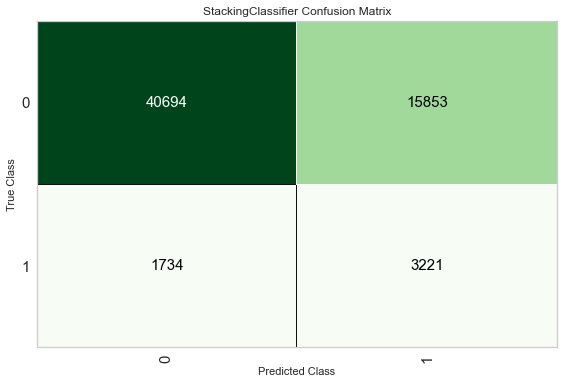

In [46]:
# confusion matrix
plot_model(stacked_lgbm, 'confusion_matrix')

# Threshold Optimisation

In [52]:
# threshold plot

def cost_score_plot(model_result):
    y_true = model_result['TARGET'].astype(int)
    y_pred_proba = model_result['Score_1']
    df_pred_proba = pd.DataFrame(y_pred_proba)
    
    score_dict = dict()

    for i in np.arange(0,1.001, 0.001):
        y_pred = df_pred_proba.applymap(lambda x: 1 if x>i else 0)['Score_1']
        score_dict[i] = custom_score(y_true, y_pred)
        
    sns.lineplot(*zip(*score_dict.items()))
    reverse_dict = dict(zip(score_dict.values(),score_dict.keys()))
    xmax = reverse_dict[max(score_dict.values())]

    plt.axvline(x= xmax, c = '#F37768')
    plt.text(xmax + 0.01, (max(score_dict.values()) - min(score_dict.values()))/2 - 0.3,  
         'Best Threshold = {}'.format(xmax), fontsize = 15)
    plt.xlim(0,1)
    plt.ylabel('Cost Score')
    plt.xlabel('Probability Threshold')
    plt.title('Probability Threshold Optimization', fontsize = 18)
    plt.show()  
    
    return xmax

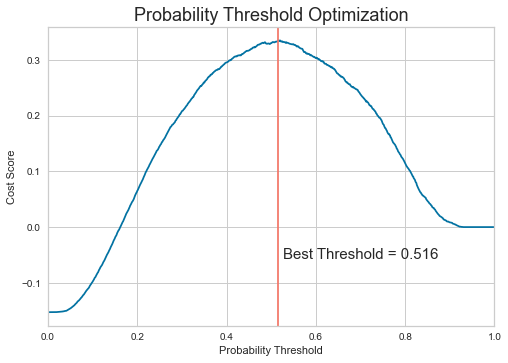

0.516


In [53]:
# Threshold for lgbm model
threshold = cost_score_plot(y_lgbm)
print(threshold)

In [55]:
y_lgbm_th = predict_model(tuned_lgbm, raw_score = True, 
                          probability_threshold = 0.516)

,Model,Accuracy,AUC,Recall,Prec.,F1,Custom Cost,Custom Score
0,Light Gradient Boosting Machine,0.7374,0.7520,0.6262,0.1783,0.2776,589625250,0.3348


In [60]:
from sklearn.metrics import confusion_matrix
y_true = y_lgbm_th['TARGET'].astype(int)
y_pred = y_lgbm_th['Label'].astype(int)
confusion_matrix(y_true, y_pred)

array([[42248, 14299],
       [ 1852,  3103]])

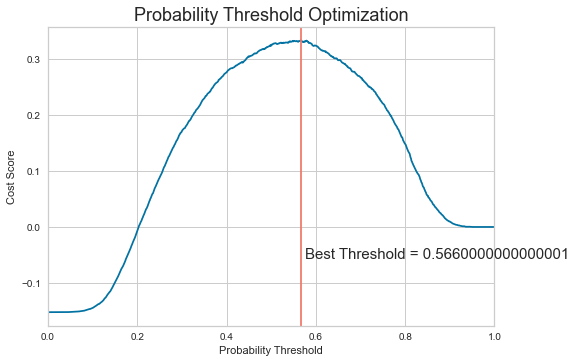

0.5660000000000001


In [61]:
# Threshold for stacked lr
threshold = cost_score_plot(y_stacked_lr)
print(threshold)

In [62]:
y_stacked_lr_th = predict_model(tuned_lgbm, raw_score = True, 
                          probability_threshold = 0.566)

,Model,Accuracy,AUC,Recall,Prec.,F1,Custom Cost,Custom Score
0,Light Gradient Boosting Machine,0.7839,0.7520,0.5457,0.1967,0.2892,572114500,0.3206


In [63]:
y_true = y_stacked_lr_th['TARGET'].astype(int)
y_pred = y_stacked_lr_th['Label'].astype(int)
confusion_matrix(y_true, y_pred)

array([[45505, 11042],
       [ 2251,  2704]])

# Finalize and save

In [65]:
# finalize a model
final_lgbm = finalize_model(tuned_lgbm)

In [66]:
# save a model
save_model(final_lgbm, 'credit_model_lgbm')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['NAME_CONTRACT_TYPE',
                                                             'CODE_GENDER',
                                                             'NAME_TYPE_SUITE',
                                                             'NAME_INCOME_TYPE',
                                                             'NAME_FAMILY_STATUS',
                                                             'NAME_HOUSING_TYPE',
                                                             'OCCUPATION_TYPE',
                                                             'ORGANIZATION_TYPE'],
                                       display_types=True,
                                       features_todrop=['SK_ID_CURR'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_